# 2. 전처리
* 이미 추출된 데이터는 크기가 128x96 이다. 
* 224x224의 조금 더 큰 크기의 정사각형으로 크롭하기 위해 원본을 사용한다.

In [1]:
import sys
import os
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

import cv2
import numpy as np
from tqdm import tqdm

from mtcnn.mtcnn import MTCNN

import tensorflow as tf
from tensorflow.keras.models import load_model, Model
from tensorflow.keras import backend as K
from tensorflow.keras.preprocessing import image
from tensorflow.keras.applications.densenet import preprocess_input

# FACE_DEFAULT_SHAPE = (128, 96)
FACE_DEFAULT_SHAPE = (224, 224)

train_df = pd.read_csv('./labels/train.csv')
valid_df = pd.read_csv('./labels/valid.csv')

Using TensorFlow backend.


In [2]:
gpus = tf.config.experimental.list_physical_devices('GPU')
# if gpus:
#     # 텐서플로가 첫 번째 GPU에 1GB 메모리만 할당하도록 제한
#     try:
#         tf.config.experimental.set_virtual_device_configuration(
#             gpus[0],
#             [tf.config.experimental.VirtualDeviceConfiguration(memory_limit=1024)])
#     except RuntimeError as e:
#         # 프로그램 시작시에 가장 장치가 설정되어야만 합니다
#         print(e)

In [3]:
# face dectector
detector = MTCNN()

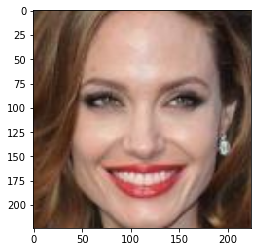

In [5]:
# 전처리 함수
def preprocess(detector, img, face_shape, file=None):
    # 얼굴 크롭
    faces = detector.detect_faces(img)
    if len(faces) != 1 :  # detect된 얼굴이 1개가 아닌 경우, 해당 데이터는 처리하지 않는다.
        return None
    
    x, y, w, h = faces[0]['box']
    
    if w < 10 or h < 10:  # detect 된 얼굴 pixel이 너무 작으면, 크롭하지 않는다.
        print('face does not exists', faces[0]['box'], file)
    else:
        # detect된 좌표를 보정한다.
        if x < 0 :
            w += x
            x = 0
        if y < 0 :
            h += y
            y = 0    
        
        # detect 패치의 중심좌표를 기준으로 정사각형으로 크롭한다.
        center_x = x + int(w/2)
        center_y = y + int(h/2)
        margin = max(w, h)
        x = center_x - int(margin/2)
        y = center_y - int(margin/2)
        if x < 0 :
            x = 0
        if y < 0 :
            y = 0  

        img = img[y:y+margin, x:x+margin, :]

    (h, w, _) = img.shape
    if h > w:
        # target shape에 행을 기준으로 맞추기
        new_w = int(w/h*face_shape[0])
        new_h = int(face_shape[0])
    else:
        # target shape에 열을 기준으로 맞추기
        new_w = int(face_shape[1])
        new_h = int(h/w*face_shape[1])
        
    try:
        img = cv2.resize(img, (new_w, new_h))    
    except Exception as e:
        msg = 'None ==>' +  file +' '+ str(img.shape) + ' ' + str(new_w) + ' ' + str(new_h) + ' ' + str(faces[0])
        print(msg)
        return None
    
    new_img = np.zeros(face_shape + (3, ))
    (h, w, _) = new_img.shape
    if face_shape[0] == new_h:
        new_img[:, int(w/2-new_w/2):int(w/2+new_w/2), :] = img
    else:    
        new_img[int(h/2-new_h/2):int(h/2+new_h/2):, :, :] = img
    return new_img

img_path = '../data/img_align_celeba/187853.jpg' # 안젤리나 졸리 - test label 5876
img = image.load_img(img_path)
img = image.img_to_array(img)
img = preprocess(detector, img, FACE_DEFAULT_SHAPE)
plt.imshow(img.astype(np.uint8))

In [5]:
src_dir_path = '../data/img_celeba'  # 전처리 대상 폴더.
dst_dir_path = '../data/img_celeba_preprocess'  # 전처리 저장 폴더.
if not os.path.exists(dst_dir_path):
    os.mkdir(dst_dir_path)
    
for k, file in tqdm(enumerate(train_df['image'])):
    if os.path.exists(os.path.join(dst_dir_path, file)):
        continue
    img = image.load_img(PATH + 'img_celeba/{}'.format(file))
    img = image.img_to_array(img)
    new_img = preprocess(detector, img, FACE_DEFAULT_SHAPE, file=file)
    if type(new_img) == type(None):
        continue 
    new_img = new_img.astype(np.uint8)
    new_img = cv2.cvtColor(new_img, cv2.COLOR_RGB2BGR)
    cv2.imwrite(os.path.join(dst_dir_path, file), new_img)

for k, file in tqdm(enumerate(valid_df['image'])):
    if os.path.exists(os.path.join(dst_dir_path, file)):
        continue
    img = image.load_img(PATH + 'img_celeba/{}'.format(file))
    img = image.img_to_array(img)
    new_img = preprocess(detector, img, FACE_DEFAULT_SHAPE, file=file)
    if type(new_img) == type(None):
        continue 
    new_img = new_img.astype(np.uint8)
    new_img = cv2.cvtColor(new_img, cv2.COLOR_RGB2BGR)
    cv2.imwrite(os.path.join(dst_dir_path, file), new_img)    #001892.jpg

56661it [2:42:01,  5.83it/s]
7080it [20:31,  5.75it/s]


In [10]:
# 전처리 라벨 파일 저장
new_train_df = train_df[train_df['image'].isin(pre_img_list)]
new_valid_df = valid_df[valid_df['image'].isin(pre_img_list)]
new_train_df.to_csv('./labels/train.pre.csv', index=False)
new_valid_df.to_csv('./labels/valid.pre.csv', index=False)

## 50명에 대한 라벨만 샘플링하여 적은 데이터 셋을 만들기

In [1]:
import pandas as pd
new_train_df= pd.read_csv('./labels/train.pre.csv')
new_valid_df= pd.read_csv('./labels/valid.pre.csv')
test_df= pd.read_csv('./labels/test.csv')

print(new_train_df.shape, new_valid_df.shape, test_df.shape)
len(set(new_train_df['label'].values)), len(set(new_valid_df['label'].values)), len(set(test_df['label'].values))

(51179, 2) (6404, 2) (7097, 2)


(2360, 2356, 2360)

In [3]:
import random
random.seed(2020)
label_list = sorted(list(set(new_train_df['label'].values) & set(new_valid_df['label'].values) & set(test_df['label'].values)))
label_list = random.sample(label_list, 48)
label_list.append(10062)  # 윤아
label_list.append(5876)  # 안젤리나 졸리
                             
new_train_df = new_train_df[new_train_df['label'].isin(label_list)]
new_valid_df = new_valid_df[new_valid_df['label'].isin(label_list)]
test_df = test_df[test_df['label'].isin(label_list)]

new_train_df.to_csv('./labels/train.pre.small.csv', index=False)
new_valid_df.to_csv('./labels/valid.pre.small.csv', index=False)
test_df.to_csv('./labels/test.small.csv', index=False)

In [4]:
len(label_list)

50

## 보기 편하게 데이터의 라벨을 파일명 앞에 추가하여 복사

In [9]:
import pandas as pd
# test_df = pd.read_csv('test.small.csv')
test_df = pd.read_csv('./labels/test.csv')
valid_df = pd.read_csv('./labels/valid.pre.csv')
print(test_df.shape)
test_df.head(1)

(7097, 2)


,image,label
0,069882.jpg,14


In [8]:
src_dir_path = '../data/img_celeba'
dst_dir_path = '../data/img_celeba_test'
import shutil
import os
import tqdm
for _, row in tqdm.tqdm(test_df.iterrows()):
    row = dict(row)
    src_path = os.path.join(src_dir_path, row['image'])
    dst_path = os.path.join(dst_dir_path, str(row['label'])+'.'+row['image'])
    shutil.copy(src_path, dst_path)

7097it [01:00, 116.91it/s]


In [10]:
src_dir_path = '../data/img_celeba'
dst_dir_path = '../data/img_celeba_valid'
import shutil
import os
import tqdm
for _, row in tqdm.tqdm(valid_df.iterrows()):
    row = dict(row)
    src_path = os.path.join(src_dir_path, row['image'])
    dst_path = os.path.join(dst_dir_path, str(row['label'])+'.'+row['image'])
    shutil.copy(src_path, dst_path)

6404it [00:25, 249.57it/s]
